# scene graph

In [1]:
import os
import shutil
import json

In [2]:
os.listdir('all_annotations')

['batch-2_ clip_62_ 000204_RF.json',
 'batch-2_ clip_516_ 000024.json',
 'batch-2_ clip_87_ 000354_RF.json',
 'batch-2_ clip_708_ 000552_RF.json',
 'batch-2_ clip_426_ 000336_RF.json',
 'batch-additional_ clip_1356_ 000492.json',
 'batch-3_ clip_352_ 000372.json',
 'batch-additional_ clip_1016_ 000174.json',
 'batch-2_ clip_348_ 000486.json',
 'batch-2_ clip_108_ 000966.json',
 'batch-2_ clip_345_ 000594_RF.json',
 'batch-2_clip_30_000558.json',
 'batch-2_ clip_171_ 000594_RF.json',
 'batch-2_ clip_68_ 000360_RF.json',
 'batch-1_clip_191_000342_RF.json',
 'batch-2_ clip_292_ 000594.json',
 'batch-2_ clip_266_ 000894_RF.json',
 'batch-3_ clip_465_ 000426_RF.json',
 'batch-2_ clip_483_ 000558.json',
 'batch-2_ clip_238_ 000594.json',
 'batch-additional_ clip_1161_ 000174.json',
 'batch-additional_ clip_620_ 000246_RF.json',
 'batch-2_clip_32_000402_RF.json',
 'batch-additional_ clip_1386_ 000312_RF.json',
 'batch-additional_ clip_1051_ 000078_RF.json',
 'batch-2_ clip_740_ 000294.json',


In [12]:
for filename in os.listdir('all_annotations'):
    # print(filename.split())
    new_filename = '_'.join([a.strip() for a in filename.split('_')][1:])
    # print(new_filename)
    s = 'seen'
    if 'batch-additional' in filename:
        s = 'unseen'
    if 'RF' in new_filename:
        # shutil.copy2(os.path.join('all_annotations',filename),os.path.join('all_annotations_cleaned',s,new_filename))
        with open(os.path.join('all_annotations',filename), 'r') as f:
            data = json.load(f)
        # print(data)
        id = data['Image ID']
        new_id = ''.join(id.split()[1:])
        data['Image ID'] = new_id
        with open(os.path.join('all_annotations_cleaned_new',s,new_filename), "w") as outfile: 
            json.dump(data, outfile) 
    else:
        with open(os.path.join('all_annotations',filename), 'r') as f:
            data = json.load(f)
        # print(data)
        id = data['Image ID']
        new_id = ''.join(id.split()[1:])
        data['Image ID'] = new_id
        rel = data['Relations']
        new_rel = [[x.strip() for x in r]for r in rel]
        # print(new_rel)
        data['Relations'] = new_rel
        with open(os.path.join('all_annotations_cleaned_new',s,new_filename), "w") as outfile: 
            json.dump(data, outfile) 

# stop position ranking

In [1]:
import pandas as pd
import pickle
import json
import os

In [2]:
df = pd.read_csv('combined_data.csv')
df['expanded'] = df.apply(lambda x:'action_data_expanded' in x['Input.image_address_bounding_box'],axis=1)
df = df[df['expanded']==True]
df.columns

Index(['HITId', 'HITTypeId', 'Title', 'Description', 'Keywords', 'Reward',
       'CreationTime', 'MaxAssignments', 'RequesterAnnotation',
       'AssignmentDurationInSeconds', 'AutoApprovalDelayInSeconds',
       'Expiration', 'NumberOfSimilarHITs', 'LifetimeInSeconds',
       'AssignmentId', 'WorkerId', 'AssignmentStatus', 'AcceptTime',
       'SubmitTime', 'AutoApprovalTime', 'ApprovalTime', 'RejectionTime',
       'RequesterFeedback', 'WorkTimeInSeconds', 'LifetimeApprovalRate',
       'Last30DaysApprovalRate', 'Last7DaysApprovalRate', 'Input.clip_address',
       'Input.image_address_bounding_box', 'Input.image_address',
       'Input.image_address_standardized', 'Input.action', 'Input.next_action',
       'Answer.annotatedResult.inputImageProperties.height',
       'Answer.annotatedResult.inputImageProperties.width',
       'Answer.annotatedResult.labelMappings.Stop Position.color',
       'Answer.annotatedResult.labeledImage.pngImageData',
       'Answer.annotations', 'Approve',

In [3]:
df_dropped = df.drop(columns=['HITId',
 'HITTypeId',
 'Title',
 'Description',
 'Keywords',
 'Reward',
 'CreationTime',
 'MaxAssignments',
 'RequesterAnnotation',
 'AssignmentDurationInSeconds',
 'AutoApprovalDelayInSeconds',
 'Expiration',
 'NumberOfSimilarHITs',
 'LifetimeInSeconds',
 'AssignmentId',
 'WorkerId',
 'AssignmentStatus',
 'AcceptTime',
 'SubmitTime',
 'AutoApprovalTime',
 'ApprovalTime',
 'RejectionTime',
 'RequesterFeedback',
 'WorkTimeInSeconds',
 'LifetimeApprovalRate',
 'Last30DaysApprovalRate',
 'Last7DaysApprovalRate',
 'Answer.annotatedResult.inputImageProperties.height',
 'Answer.annotatedResult.inputImageProperties.width',
 'Answer.annotatedResult.labelMappings.Stop Position.color',
 'Approve',
 'Reject',
 'expanded'])

In [4]:
df_dropped.columns

Index(['Input.clip_address', 'Input.image_address_bounding_box',
       'Input.image_address', 'Input.image_address_standardized',
       'Input.action', 'Input.next_action',
       'Answer.annotatedResult.labeledImage.pngImageData',
       'Answer.annotations'],
      dtype='object')

In [5]:
def impute_missing_pos(r):
    row = r['Answer.annotations']
    if sum(['Position' in a for a in row.split()])<6:
        row_split = row.split(',')
        x = [int(a.split()[1]) for a in row_split  if 'Position' in a]
        for i in range(1,7):
            if i not in x:
                missing = i
        new_pos = []
        for pos in row_split:
            if pos=='':
                new_pos.append(f'Position {missing}')
            else:
                new_pos.append(pos)
        return ','.join(new_pos)
    return row

In [6]:
df_dropped['Answer.annotations']=df_dropped.apply(impute_missing_pos,axis=1)[430]

In [7]:
#verify imputation
temp = df_dropped['Answer.annotations'].apply(lambda x: sum(['Position' in a for a in x.split()]))
df_dropped[temp<6]

,Input.clip_address,Input.image_address_bounding_box,Input.image_address,Input.image_address_standardized,Input.action,Input.next_action,Answer.annotatedResult.labeledImage.pngImageData,Answer.annotations


In [8]:
df_dropped.head()

,Input.clip_address,Input.image_address_bounding_box,Input.image_address,Input.image_address_standardized,Input.action,Input.next_action,Answer.annotatedResult.labeledImage.pngImageData,Answer.annotations
0,https://stop-position-ranker.s3.ap-northeast-1...,https://stop-position-ranker.s3.ap-northeast-1...,https://stop-position-ranker.s3.ap-northeast-1...,clip_355/images/000594.png,walking along the side of the road,stop and wave down a taxi,iVBORw0KGgoAAAANSUhEUgAACpAAAAXwAQMAAABl6wiCAA...,"Position 3,Position 4,Position 5,Position 6,Po..."
1,https://stop-position-ranker.s3.ap-northeast-1...,https://stop-position-ranker.s3.ap-northeast-1...,https://stop-position-ranker.s3.ap-northeast-1...,clip_65/images/000534.png,walking on the road,call the taxi driver to come fast,iVBORw0KGgoAAAANSUhEUgAACpAAAAXwAQMAAABl6wiCAA...,"Position 3,Position 4,Position 5,Position 6,Po..."
2,https://stop-position-ranker.s3.ap-northeast-1...,https://stop-position-ranker.s3.ap-northeast-1...,https://stop-position-ranker.s3.ap-northeast-1...,clip_355/images/000594.png,walking along the side of the road,slow down and read the signs in front of her,iVBORw0KGgoAAAANSUhEUgAACpAAAAXwAQMAAABl6wiCAA...,"Position 3,Position 4,Position 5,Position 6,Po..."
3,https://stop-position-ranker.s3.ap-northeast-1...,https://stop-position-ranker.s3.ap-northeast-1...,https://stop-position-ranker.s3.ap-northeast-1...,clip_355/images/000594.png,walking along the side of the road,enter the shop,iVBORw0KGgoAAAANSUhEUgAACpAAAAXwAQMAAABl6wiCAA...,"Position 3,Position 4,Position 5,Position 6,Po..."
4,https://stop-position-ranker.s3.ap-northeast-1...,https://stop-position-ranker.s3.ap-northeast-1...,https://stop-position-ranker.s3.ap-northeast-1...,clip_628/images/000366.png,walking on the road,meet a woman crossing a gravel road,iVBORw0KGgoAAAANSUhEUgAACpAAAAXwAQMAAABl6wiCAA...,"Position 3,Position 4,Position 5,Position 6,Po..."


In [9]:
def map_ranking(row):
    clip_no,_,position_ranking_no = row['Input.image_address_standardized'].split('/')
    position_ranking_no = position_ranking_no.split('.')[0]
    with open('clip_number_to_batch.pkl', 'rb') as f:
        data_dict = pickle.load(f)
    batch_no = data_dict[clip_no][position_ranking_no][0]
    # print(batch_no,clip_no,position_ranking_no)
    # print(row['Answer.annotations'])
    position_list_old = [a.split()[1] for a in row['Answer.annotations'].split(',')]
    with open(f'/Volumes/Untitled/scene_graph_batch-{batch_no}/panoptic_scene_graph_batch_{batch_no}/{clip_no}/{position_ranking_no}_panoptic_segments_updated.json', 'r') as f:
        segments_info = json.load(f)
    park_spot_id = []
    for segment in segments_info:
        if segment['category_id']==65:
            park_spot_id.append(segment['id'])
    position_list_new = [str(int(a)+min(park_spot_id)-1) for a in position_list_old]
    return ','.join(position_list_new)


In [ ]:
# df_dropped[:2].apply(map_ranking,axis=1)

0    64,65,66,67,62,63
1    35,36,37,38,33,34
dtype: object

In [ ]:
# with open('Stop-Position-Ranker/example_data/clip_3/000300_panoptic_segments_updated.json', 'r') as f:
#     segments_info = json.load(f)
# park_spot_id = []
# for segment in segments_info:
#     if segment['category_id']==65:
#         park_spot_id.append(segment['id'])
# print(park_spot_id)

[65, 66, 67, 68, 69, 70]


In [10]:
df_dropped['position_ranking_by_id'] = df_dropped.apply(map_ranking,axis=1)

In [11]:
# json file path column
seen_list = [a.split('.')[0] for a in os.listdir('all_annotations_cleaned/seen') if 'RF' not in a]
unseen_list = [a.split('.')[0] for a in os.listdir('all_annotations_cleaned/unseen') if 'RF' not in a]
def scene_json_map(row):
    clip_no,_,position_ranking_no = row['Input.image_address_standardized'].split('/')
    position_ranking_no = position_ranking_no.split('.')[0]
    name = clip_no+'_'+position_ranking_no
    if name in seen_list:
        path = f'seen/{name}.json'
    else:
        path = f'unseen/{name}.json'
    return path
df_dropped['Scene_graph_JSON'] = df_dropped.apply(scene_json_map,axis=1)

In [12]:
#titan clip person id
df_dropped['Titan Clip ID'] = df_dropped.apply(lambda x:x['Input.clip_address'].split('/')[4],axis=1)
df_dropped['Titan Person ID'] = df_dropped.apply(lambda x:x['Input.clip_address'].split('/')[5].split('.')[0],axis=1)

In [13]:
for i,row in df_dropped.iterrows():
    json_path = f'all_annotations_cleaned/{row['Scene_graph_JSON']}'
    with open(json_path) as f:
        scene_graph = json.load(f)
    all_object_list = set()
    for a,b,c in scene_graph['Relations']:
        all_object_list.add(a.strip())
        all_object_list.add(b.strip())
    for id in row['position_ranking_by_id'].split(','):
        if id not in all_object_list:
            print(row['Input.image_address_standardized'])

clip_330/images/000690.png
clip_330/images/000690.png
clip_330/images/000690.png
clip_330/images/000690.png
clip_330/images/000690.png
clip_330/images/000690.png
clip_330/images/000690.png
clip_330/images/000690.png
clip_330/images/000690.png
clip_330/images/000690.png
clip_330/images/000690.png
clip_330/images/000690.png
clip_330/images/000690.png
clip_330/images/000690.png
clip_330/images/000690.png
clip_330/images/000690.png
clip_330/images/000690.png
clip_330/images/000690.png
clip_330/images/000588.png
clip_330/images/000588.png
clip_330/images/000588.png
clip_330/images/000588.png
clip_330/images/000588.png
clip_330/images/000588.png
clip_330/images/000588.png
clip_330/images/000588.png
clip_330/images/000588.png
clip_330/images/000588.png
clip_330/images/000588.png
clip_330/images/000588.png
clip_330/images/000588.png
clip_330/images/000588.png
clip_330/images/000588.png
clip_330/images/000588.png
clip_330/images/000588.png
clip_330/images/000588.png
clip_46/images/000594.png
cl

In [14]:
def position_scene_diff(row):
    json_path = f'all_annotations_cleaned/{row['Scene_graph_JSON']}'
    with open(json_path) as f:
        scene_graph = json.load(f)
    all_object_list = set()
    for a,b,c in scene_graph['Relations']:
        all_object_list.add(a.strip())
        all_object_list.add(b.strip())
    diff = []
    pos_list =row['position_ranking_by_id'].split(',')
    for id in pos_list :
        if id not in all_object_list:
            diff.append((id,pos_list.index(id)))
    return diff

In [15]:
df_dropped['ranking_not_in_scene_graph'] = df_dropped.apply(position_scene_diff,axis=1)

In [16]:
df_dropped.head()

,Input.clip_address,Input.image_address_bounding_box,Input.image_address,Input.image_address_standardized,Input.action,Input.next_action,Answer.annotatedResult.labeledImage.pngImageData,Answer.annotations,position_ranking_by_id,Scene_graph_JSON,Titan Clip ID,Titan Person ID,ranking_not_in_scene_graph
0,https://stop-position-ranker.s3.ap-northeast-1...,https://stop-position-ranker.s3.ap-northeast-1...,https://stop-position-ranker.s3.ap-northeast-1...,clip_355/images/000594.png,walking along the side of the road,stop and wave down a taxi,iVBORw0KGgoAAAANSUhEUgAACpAAAAXwAQMAAABl6wiCAA...,"Position 3,Position 4,Position 5,Position 6,Po...","64,65,66,67,62,63",seen/clip_355_000594.json,clip_355,9,[]
1,https://stop-position-ranker.s3.ap-northeast-1...,https://stop-position-ranker.s3.ap-northeast-1...,https://stop-position-ranker.s3.ap-northeast-1...,clip_65/images/000534.png,walking on the road,call the taxi driver to come fast,iVBORw0KGgoAAAANSUhEUgAACpAAAAXwAQMAAABl6wiCAA...,"Position 3,Position 4,Position 5,Position 6,Po...","35,36,37,38,33,34",seen/clip_65_000534.json,clip_65,0,[]
2,https://stop-position-ranker.s3.ap-northeast-1...,https://stop-position-ranker.s3.ap-northeast-1...,https://stop-position-ranker.s3.ap-northeast-1...,clip_355/images/000594.png,walking along the side of the road,slow down and read the signs in front of her,iVBORw0KGgoAAAANSUhEUgAACpAAAAXwAQMAAABl6wiCAA...,"Position 3,Position 4,Position 5,Position 6,Po...","64,65,66,67,62,63",seen/clip_355_000594.json,clip_355,9,[]
3,https://stop-position-ranker.s3.ap-northeast-1...,https://stop-position-ranker.s3.ap-northeast-1...,https://stop-position-ranker.s3.ap-northeast-1...,clip_355/images/000594.png,walking along the side of the road,enter the shop,iVBORw0KGgoAAAANSUhEUgAACpAAAAXwAQMAAABl6wiCAA...,"Position 3,Position 4,Position 5,Position 6,Po...","64,65,66,67,62,63",seen/clip_355_000594.json,clip_355,9,[]
4,https://stop-position-ranker.s3.ap-northeast-1...,https://stop-position-ranker.s3.ap-northeast-1...,https://stop-position-ranker.s3.ap-northeast-1...,clip_628/images/000366.png,walking on the road,meet a woman crossing a gravel road,iVBORw0KGgoAAAANSUhEUgAACpAAAAXwAQMAAABl6wiCAA...,"Position 3,Position 4,Position 5,Position 6,Po...","65,66,67,68,63,64",seen/clip_628_000366.json,clip_628,26,[]


In [248]:
df_dropped.to_csv('combined_data_expanded_cleaned.csv',index=False)

# analyis - unused

In [159]:
import pandas as pd
df = pd.read_csv('combined_data_remapped.csv')

In [160]:
df['expanded'] = df.apply(lambda x:'action_data_expanded' in x['Input.image_address_bounding_box'],axis=1)

In [161]:
d = {}
for i,row in df.iterrows():
    cn = row['Input.image_address_standardized']
    if cn not in d:d[cn]=[]

    if row['expanded'] not in d[cn]: d[cn].append(row['expanded'])

In [162]:
d.items()

dict_items([('clip_355/images/000594.png', [True]), ('clip_65/images/000534.png', [True]), ('clip_628/images/000366.png', [True]), ('clip_74/images/000504.png', [True]), ('clip_376/images/000876.png', [True]), ('clip_317/images/001014.png', [True]), ('clip_133/images/000954.png', [True]), ('clip_310/images/000294.png', [True]), ('clip_15/images/000318.png', [True]), ('clip_333/images/000630.png', [True]), ('clip_133/images/000486.png', [True]), ('clip_691/images/000594.png', [True, False]), ('clip_237/images/000462.png', [True]), ('clip_756/images/000588.png', [True]), ('clip_550/images/000594.png', [True]), ('clip_327/images/000210.png', [True]), ('clip_35/images/000594.png', [True]), ('clip_125/images/000558.png', [True]), ('clip_425/images/000594.png', [True]), ('clip_194/images/000588.png', [True]), ('clip_156/images/000390.png', [True]), ('clip_82/images/001032.png', [True]), ('clip_62/images/000594.png', [True, False]), ('clip_116/images/000294.png', [True]), ('clip_46/images/000

In [163]:
d

{'clip_355/images/000594.png': [True],
 'clip_65/images/000534.png': [True],
 'clip_628/images/000366.png': [True],
 'clip_74/images/000504.png': [True],
 'clip_376/images/000876.png': [True],
 'clip_317/images/001014.png': [True],
 'clip_133/images/000954.png': [True],
 'clip_310/images/000294.png': [True],
 'clip_15/images/000318.png': [True],
 'clip_333/images/000630.png': [True],
 'clip_133/images/000486.png': [True],
 'clip_691/images/000594.png': [True, False],
 'clip_237/images/000462.png': [True],
 'clip_756/images/000588.png': [True],
 'clip_550/images/000594.png': [True],
 'clip_327/images/000210.png': [True],
 'clip_35/images/000594.png': [True],
 'clip_125/images/000558.png': [True],
 'clip_425/images/000594.png': [True],
 'clip_194/images/000588.png': [True],
 'clip_156/images/000390.png': [True],
 'clip_82/images/001032.png': [True],
 'clip_62/images/000594.png': [True, False],
 'clip_116/images/000294.png': [True],
 'clip_46/images/000198.png': [True],
 'clip_622/images/

In [164]:
for key,value in d.items():
    if len(value)>1:
        print(key)

clip_691/images/000594.png
clip_62/images/000594.png
clip_761/images/000594.png
clip_621/images/000594.png
clip_762/images/000594.png
clip_392/images/000594.png
clip_746/images/000594.png
clip_634/images/000594.png
clip_679/images/000594.png
clip_98/images/000594.png
clip_551/images/000594.png
clip_688/images/000594.png
clip_759/images/000594.png
clip_748/images/000594.png
clip_320/images/000594.png
clip_780/images/000594.png
clip_760/images/000594.png
clip_386/images/000594.png
clip_327/images/001074.png
clip_7/images/000594.png
clip_337/images/000594.png
clip_632/images/000594.png
clip_384/images/000594.png
clip_518/images/000594.png
clip_24/images/000594.png
clip_394/images/000594.png
clip_374/images/000594.png
clip_176/images/000594.png
clip_433/images/000594.png
clip_114/images/000594.png
clip_377/images/000594.png
clip_332/images/000594.png
clip_281/images/001194.png
clip_18/images/000594.png
clip_546/images/000594.png
clip_405/images/000594.png
clip_784/images/000594.png
clip_15

In [165]:
x = os.listdir('all_annotations_cleaned/seen')
y = os.listdir('all_annotations_cleaned/unseen')
for a in y:
    if a in x:
        print(a)

In [166]:
temp = df_dropped['Answer.annotations'].apply(lambda x:sum('Position' in a for a in x.split(',')))
df_dropped[temp!=6]
# for a in df_dropped[temp!=6]['Answer.annotations']:
#     print(a)

,Input.clip_address,Input.image_address_bounding_box,Input.image_address,Input.image_address_standardized,Input.action,Input.next_action,Answer.annotations,position_ranking_by_id,Scene_graph_JSON,Titan Clip ID,Titan Person ID


In [ ]:
#check if every stop position object in panoptic is also in scene graph
for i,row in df_dropped.iterrows():
    clip_no,_,position_ranking_no = row['Input.image_address_standardized'].split('/')
    position_ranking_no = position_ranking_no.split('.')[0]
    with open('clip_number_to_batch.pkl', 'rb') as f:
        data_dict = pickle.load(f)
    batch_no = data_dict[clip_no][position_ranking_no][0]
    with open(f'/Volumes/Untitled/scene_graph_batch-{batch_no}/panoptic_scene_graph_batch_{batch_no}/{clip_no}/{position_ranking_no}_panoptic_segments_updated.json', 'r') as f:
        segments_info = json.load(f)
    park_spot_id = []
    for segment in segments_info:
        if segment['category_id']==65:
            park_spot_id.append(segment['id'])

    json_path = f'all_annotations_cleaned/{row['Scene_graph_JSON']}'
    with open(json_path) as f:
        scene_graph = json.load(f)
    all_object_list = set()
    for a,b,c in scene_graph['Relations']:
        all_object_list.add(int(a.strip()))
        all_object_list.add(int(b.strip()))

    for id in park_spot_id:
        if id not in all_object_list:
            print(row['Input.image_address_standardized'],park_spot_id,all_object_list)    

clip_783/images/000522.png [69, 70, 71, 72, 73, 74] {1, 2, 3, 4, 5, 6, 11, 13, 20, 23, 28, 33, 41, 44, 45, 50, 51, 53, 61, 64, 65, 70, 72, 75}
clip_783/images/000522.png [69, 70, 71, 72, 73, 74] {1, 2, 3, 4, 5, 6, 11, 13, 20, 23, 28, 33, 41, 44, 45, 50, 51, 53, 61, 64, 65, 70, 72, 75}
clip_783/images/000522.png [69, 70, 71, 72, 73, 74] {1, 2, 3, 4, 5, 6, 11, 13, 20, 23, 28, 33, 41, 44, 45, 50, 51, 53, 61, 64, 65, 70, 72, 75}
clip_783/images/000522.png [69, 70, 71, 72, 73, 74] {1, 2, 3, 4, 5, 6, 11, 13, 20, 23, 28, 33, 41, 44, 45, 50, 51, 53, 61, 64, 65, 70, 72, 75}
clip_783/images/000522.png [69, 70, 71, 72, 73, 74] {1, 2, 3, 4, 5, 6, 11, 13, 20, 23, 28, 33, 41, 44, 45, 50, 51, 53, 61, 64, 65, 70, 72, 75}
clip_783/images/000522.png [69, 70, 71, 72, 73, 74] {1, 2, 3, 4, 5, 6, 11, 13, 20, 23, 28, 33, 41, 44, 45, 50, 51, 53, 61, 64, 65, 70, 72, 75}
clip_783/images/000522.png [69, 70, 71, 72, 73, 74] {1, 2, 3, 4, 5, 6, 11, 13, 20, 23, 28, 33, 41, 44, 45, 50, 51, 53, 61, 64, 65, 70, 72, 75}

In [17]:
#check if every stop position object in scene graph is also in panoptic
for i,row in df_dropped.iterrows():
    clip_no,_,position_ranking_no = row['Input.image_address_standardized'].split('/')
    position_ranking_no = position_ranking_no.split('.')[0]
    with open('clip_number_to_batch.pkl', 'rb') as f:
        data_dict = pickle.load(f)
    batch_no = data_dict[clip_no][position_ranking_no][0]
    with open(f'/Volumes/Untitled/scene_graph_batch-{batch_no}/panoptic_scene_graph_batch_{batch_no}/{clip_no}/{position_ranking_no}_panoptic_segments_updated.json', 'r') as f:
        segments_info = json.load(f)
    park_spot_id = []
    for segment in segments_info:
        if segment['category_id']==65:
            park_spot_id.append(segment['id'])

    json_path = f'all_annotations_cleaned/{row['Scene_graph_JSON'].split('.')[0]}_RF.json'
    with open(json_path) as f:
        scene_graph = json.load(f)
    scene_graph_park_spot_id = set()
    for a,b,c in scene_graph['Relations']:
        if "'Stop Positions'" in a:
            scene_graph_park_spot_id.add(int(a.split()[1]))
        if "'Stop Positions'" in b:
            scene_graph_park_spot_id.add(int(b.split()[1]))
    for id in scene_graph_park_spot_id:
        if id not in park_spot_id:
            print(row['Input.image_address_standardized'],park_spot_id,scene_graph_park_spot_id)   

In [257]:
a

"subject:  62 'Stop Positions'"

<Axes: xlabel='Answer.annotations'>

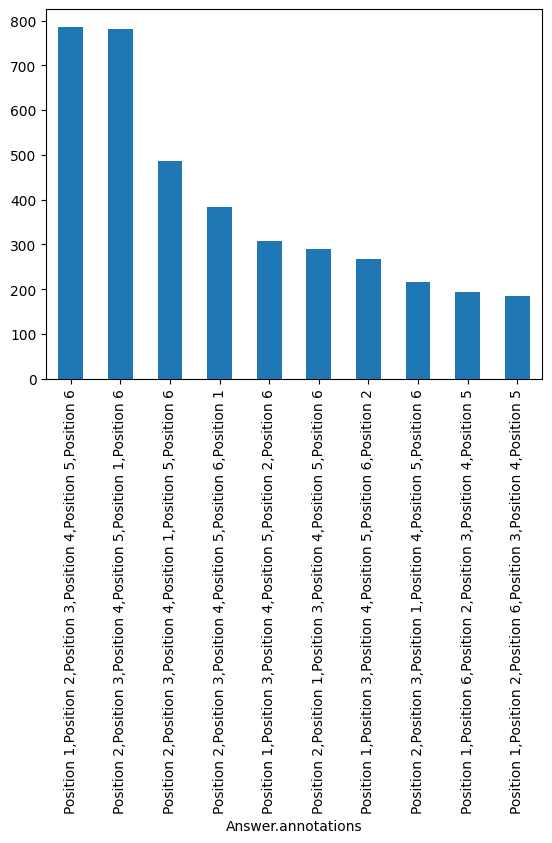

In [167]:
df_dropped['Answer.annotations'].value_counts()[:10].plot(kind='bar')

In [168]:
df['WorkerId'].value_counts()

WorkerId
A21PC6ZS98FGB5    1804
A3DJ0UVMQRZ32R    1720
A20G8SL4ZZ38FL    1589
AJSOHKPWWDS3G     1531
A3D2P33SYYDMD     1202
A1L7P9QOS3HFGH     419
A4TJ9GW2UVMG       277
A25Z5OI3JJK3IP     227
A3QVB1ZA646NIF     186
A2Y0HZSZTQAVDW     159
A1JDPMVFB8HNMH     154
A1FJAGBOIH9B7A      63
A1KLLYT0ITXDK4      48
AKQAI78JTXXC9       44
A2ATPVV665TR66      29
A9G5PXNUA5V8O       24
A1LPSF8B1HAPYS      12
A1A5USR95BR1T5       9
A1HKYY6XI2OHO1       5
A1SMWIBTQ2AESU       2
A1L3937MY09J3I       1
A1HM7K2CGZQHVL       1
Name: count, dtype: int64

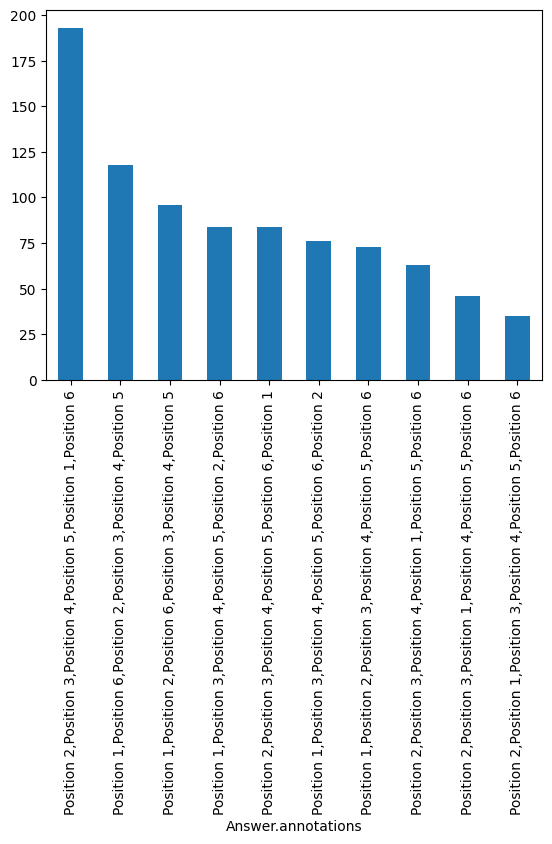

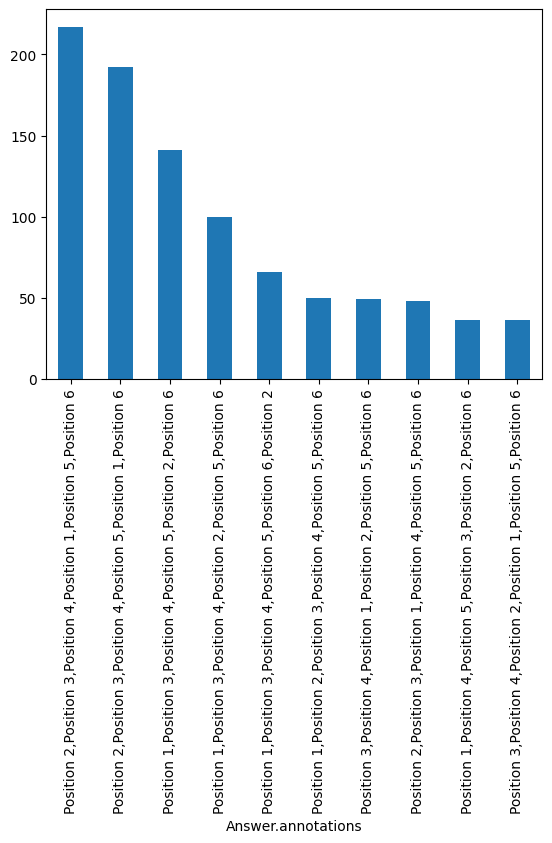

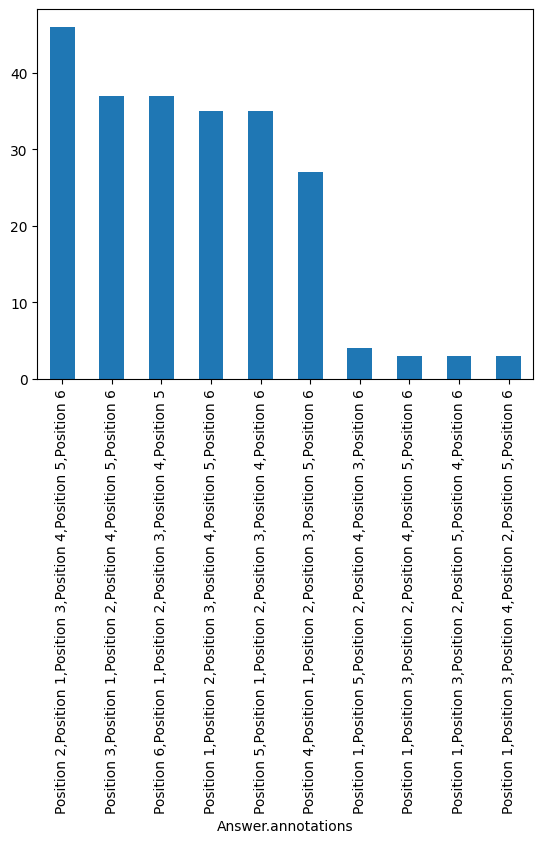

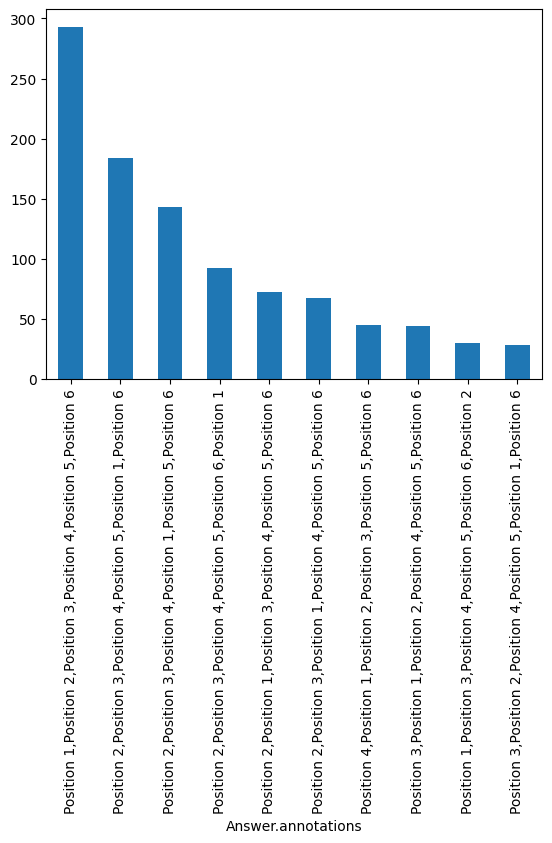

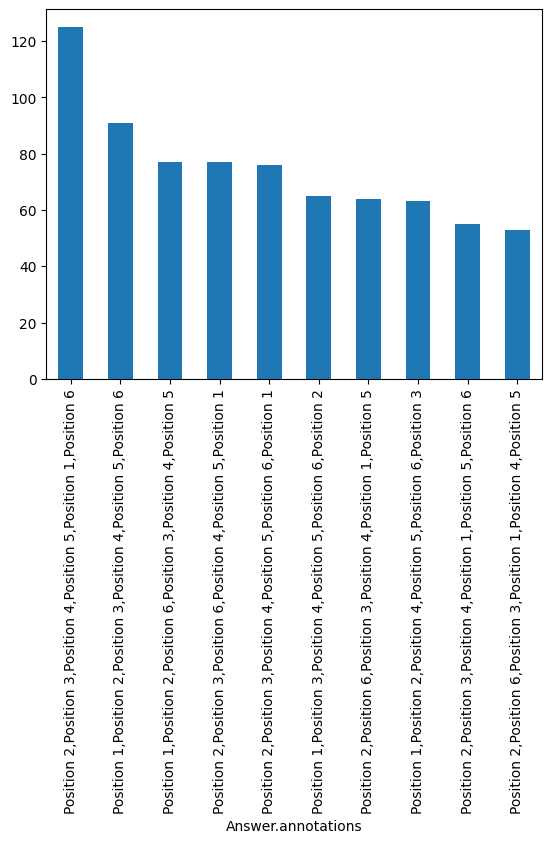

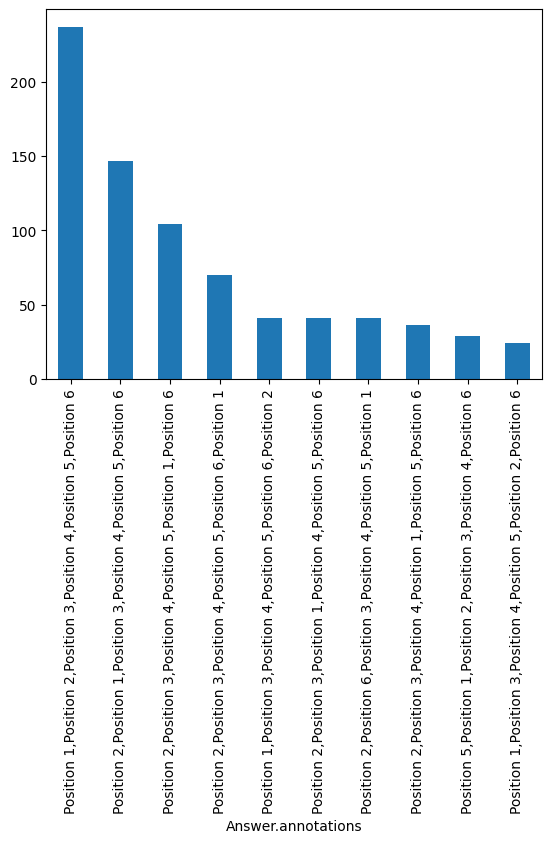

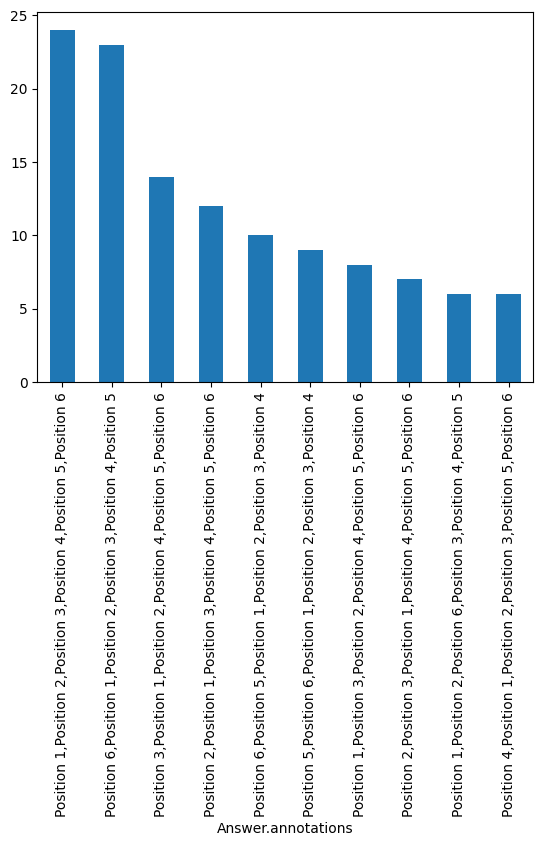

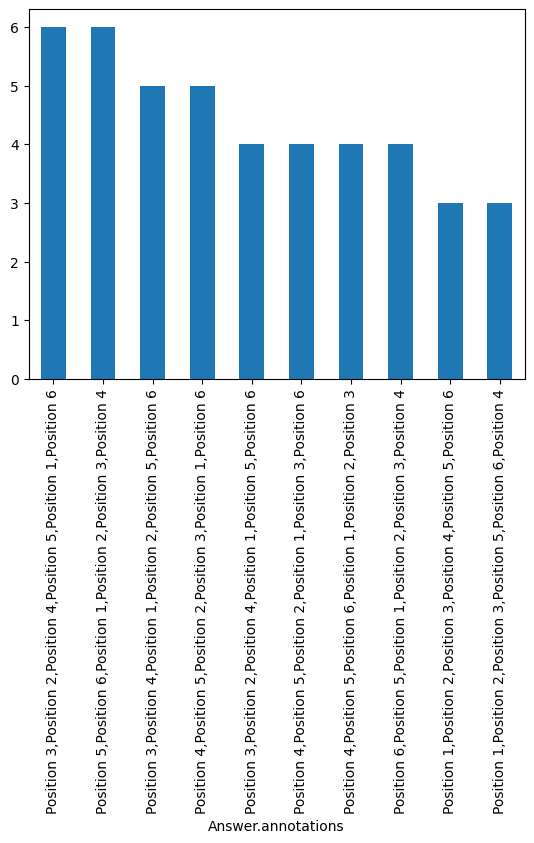

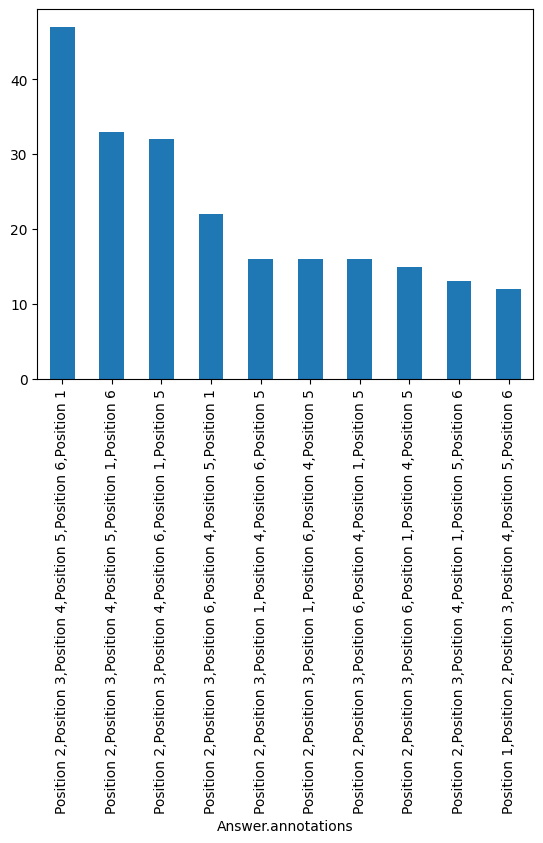

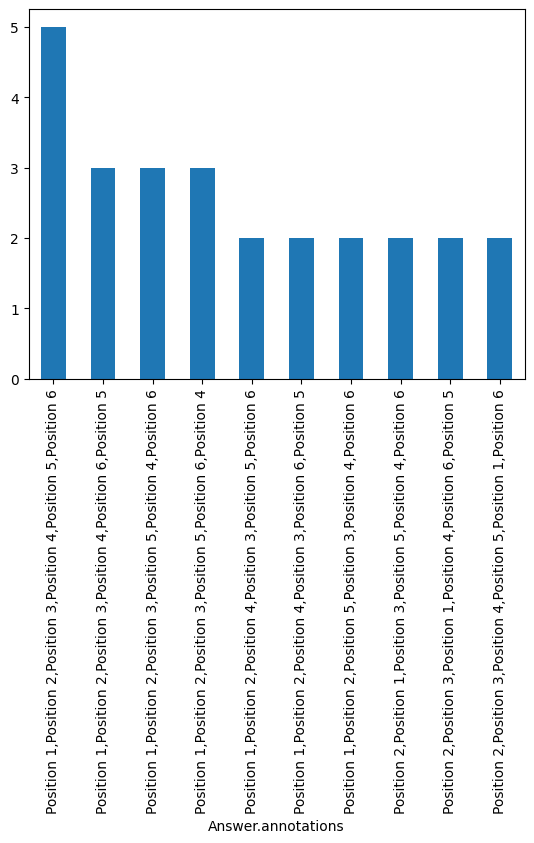

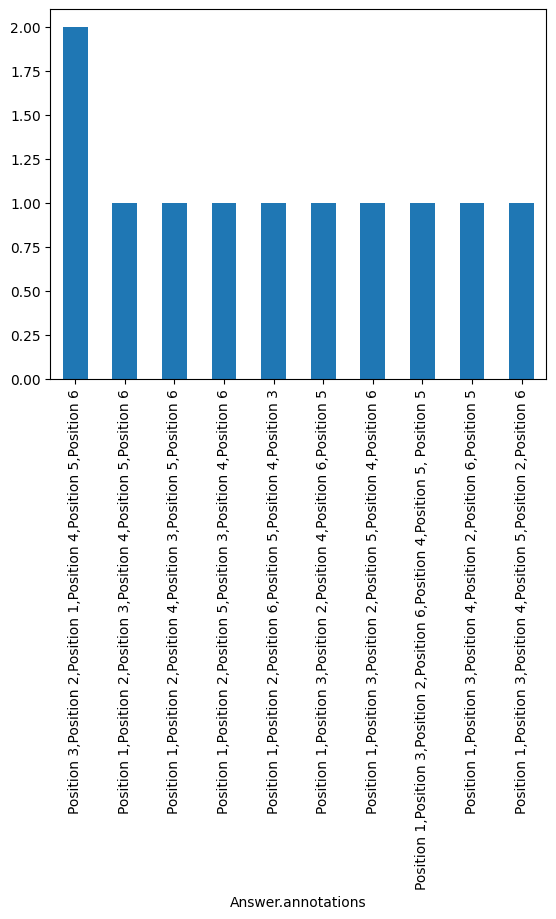

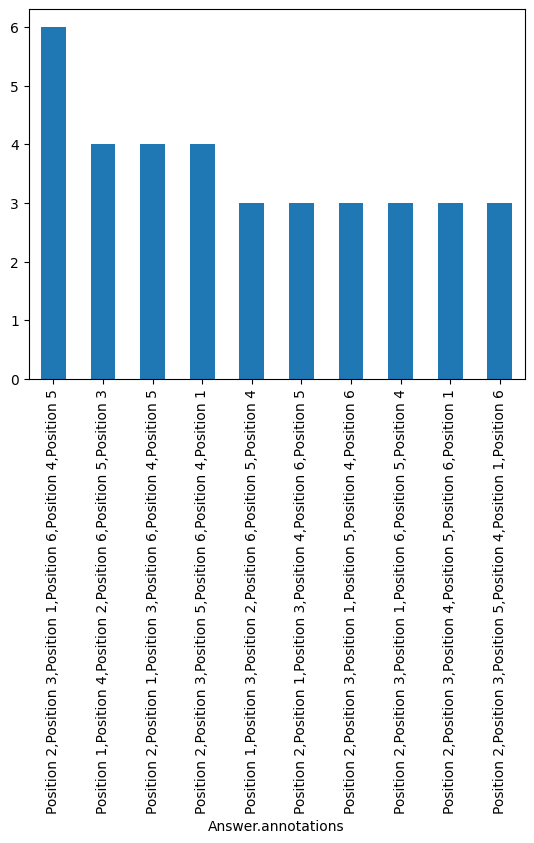

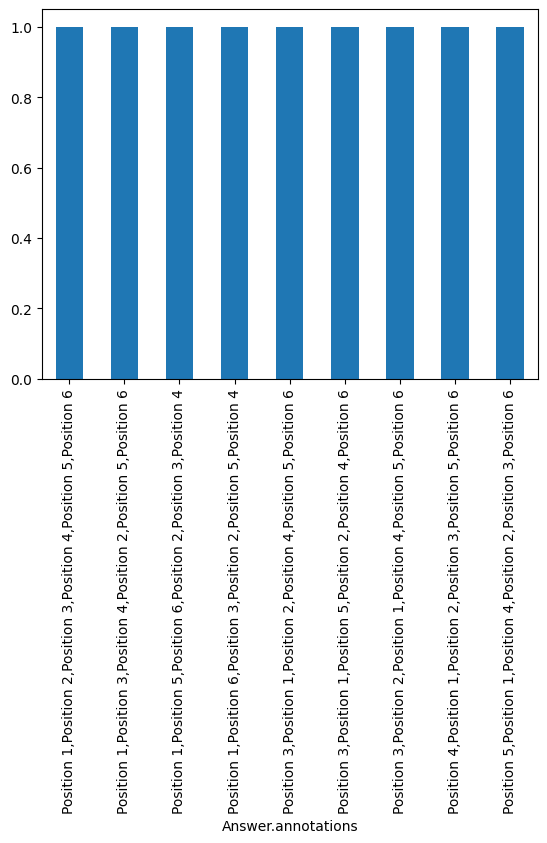

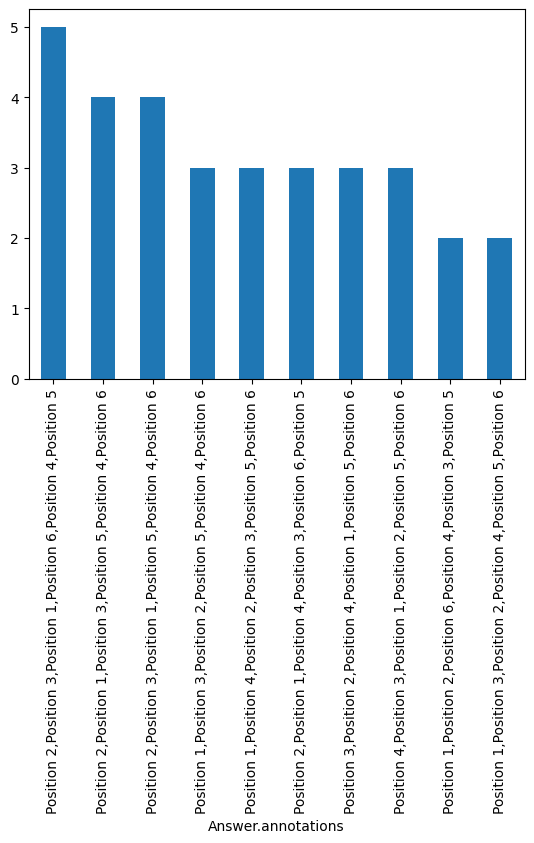

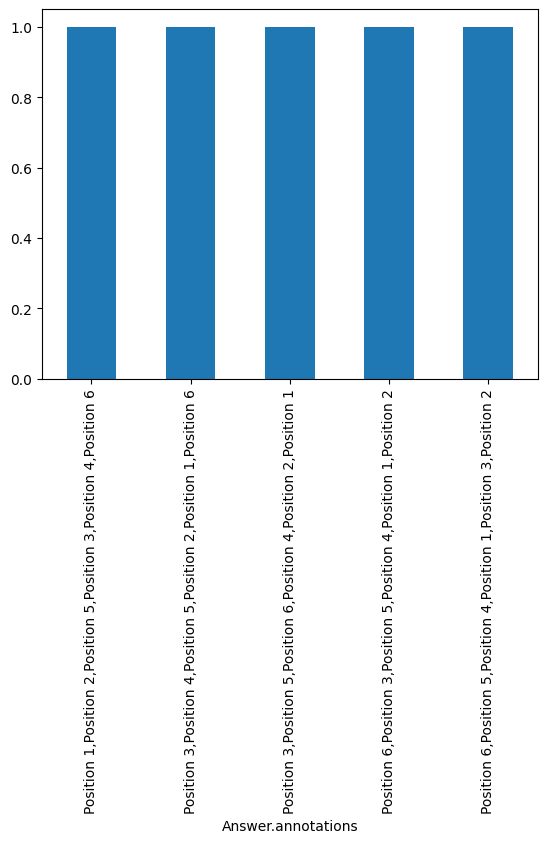

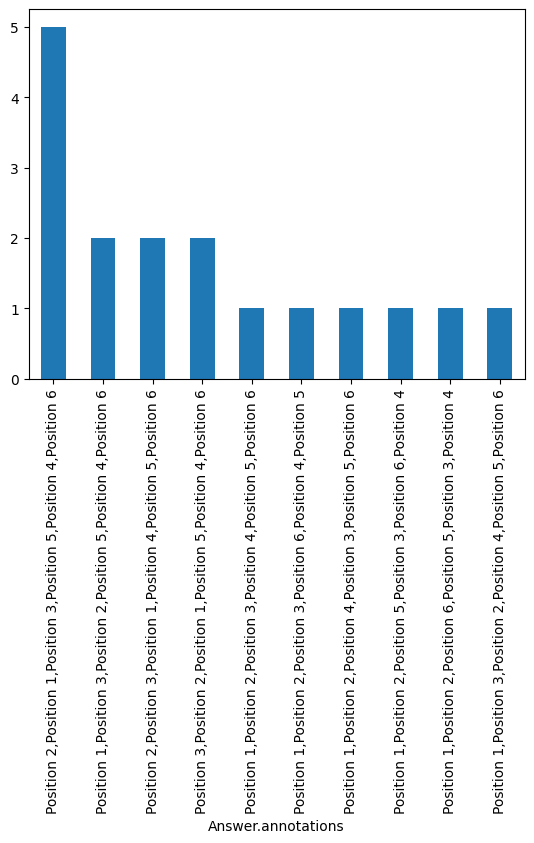

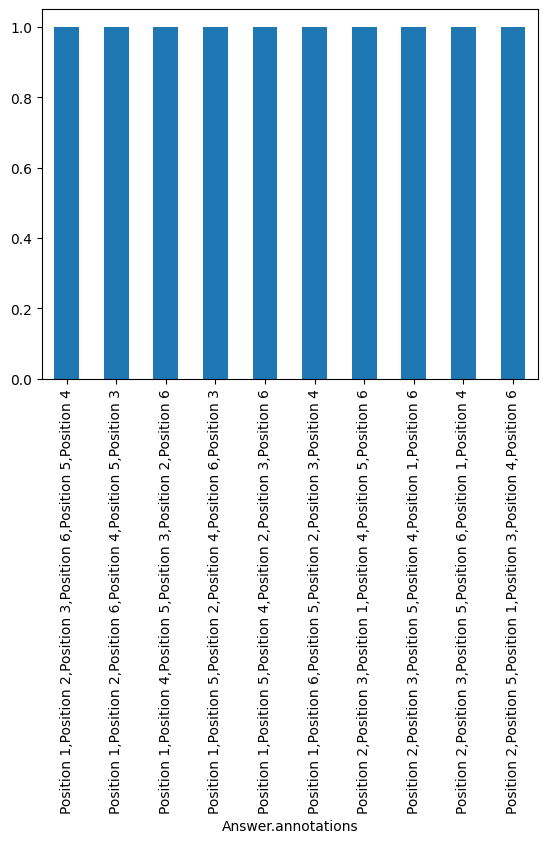

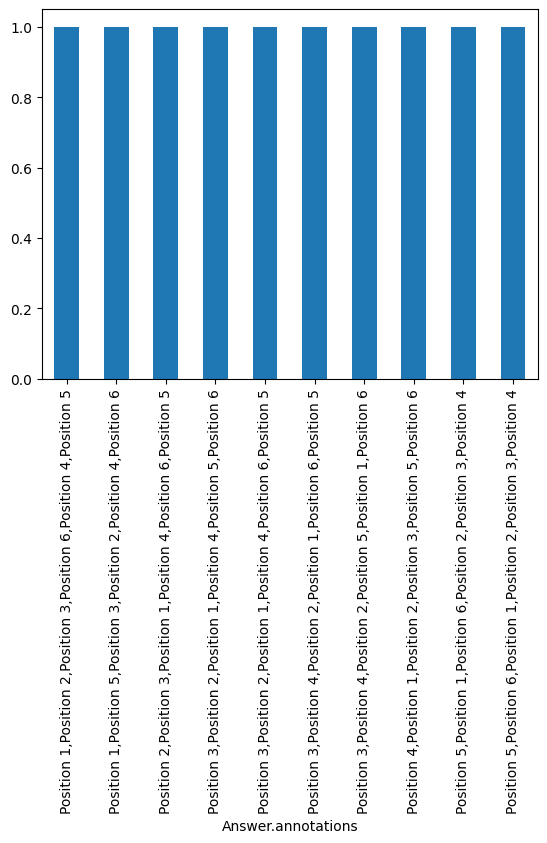

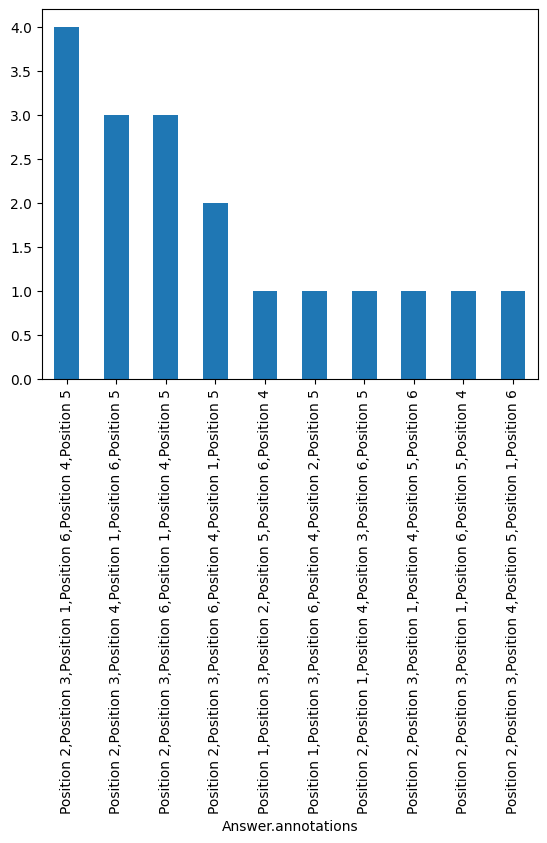

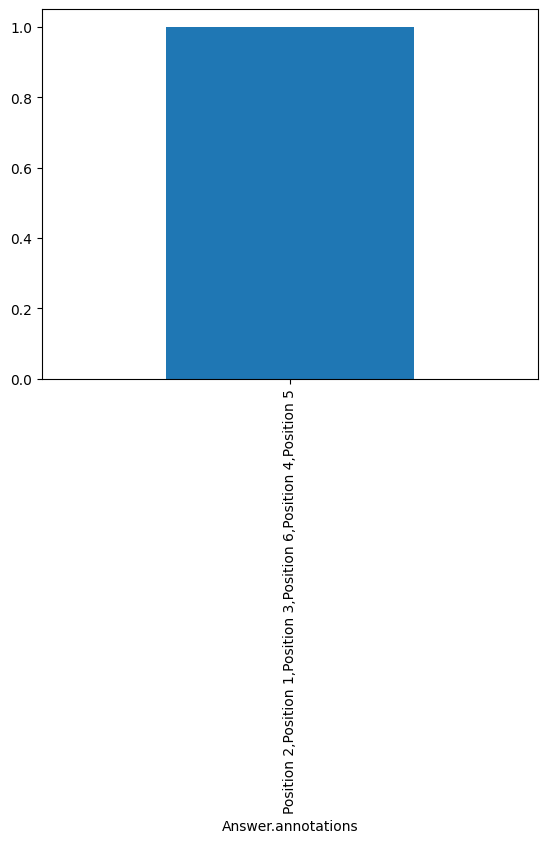

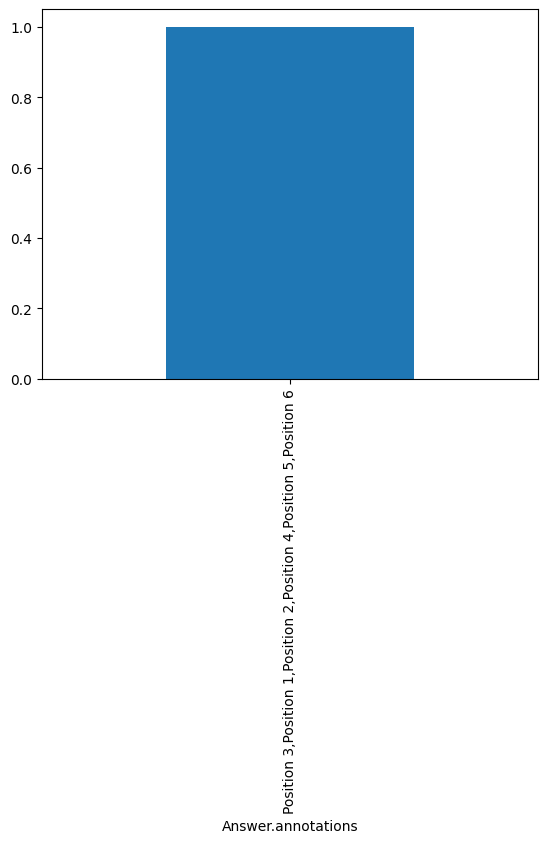

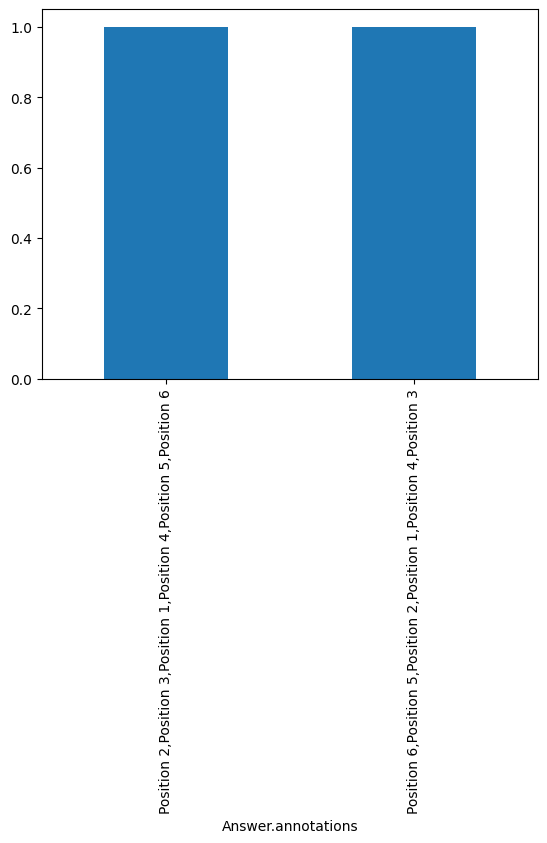

In [169]:
import matplotlib.pyplot as plt
for worker in df['WorkerId'].unique():
    df.groupby('WorkerId')['Answer.annotations'].value_counts()[worker][:10].plot(kind='bar')
    plt.show()  
